## Risk Policy

## Import Libraries

In [2]:
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
import shap

## Load Data

In [3]:
X_train = pd.read_csv('input/Train_after_modeling.csv', sep=',').set_index('id')
X_val = pd.read_csv('input/Val_after_modeling.csv', sep=',').set_index('id')
X_test = pd.read_csv('input/Test_after_modeling.csv', sep=',').set_index('id')



In [4]:
X_test.head()

,loan_amnt,term,emp_length,annual_inc,addr_state,dti,mths_since_recent_inq,bc_open_to_buy,num_op_rev_tl,home_ownership_MORTGAGE,home_ownership_OTHERS,home_ownership_OWN,home_ownership_RENT,target,y_pred,y_score
id,,,,,,,,,,,,,,,,
93952372,0.065237,-0.564595,1.127005,-0.087128,0.875601,0.251863,0.785456,-0.405674,1.287908,0,0,1,0,0,0,0.180158
15741465,1.211835,-0.564595,1.127005,-0.224658,-0.504480,0.778456,0.052781,-0.605990,2.188259,1,0,0,0,0,0,0.197830
55198988,-1.482670,-0.564595,-1.386826,-0.637249,0.507580,-0.985720,0.000250,-0.644057,-0.962967,0,0,0,1,0,0,0.136556
16642377,-0.049423,1.771181,1.127005,0.256697,-0.504480,-0.178986,0.052781,-0.503170,-0.512792,1,0,0,0,0,0,0.182997
1562329,-0.671452,-0.564595,0.568376,-0.704790,0.691590,-0.170121,0.000250,-0.636271,-0.287704,0,0,0,1,0,0,0.214186


In [5]:
X_test.columns


Index(['loan_amnt', 'term', 'emp_length', 'annual_inc', 'addr_state', 'dti',
       'mths_since_recent_inq', 'bc_open_to_buy', 'num_op_rev_tl',
       'home_ownership_MORTGAGE', 'home_ownership_OTHERS',
       'home_ownership_OWN', 'home_ownership_RENT', 'target', 'y_pred',
       'y_score'],
      dtype='object')

## Policy Function

In [6]:
def FaixasDecil(dataframe,scorename,targetname):
    import pandas as pd
    import numpy as np 
    
    dataframe['good'] = 1 - dataframe[targetname]
    dataframe['bucket'] = pd.qcut(dataframe[scorename], 10,duplicates='drop')
    grouped = dataframe.groupby('bucket', as_index = False)
    agg1 = grouped.min()[scorename].values
    agg1 = pd.DataFrame(data=agg1, columns = ['min_scr'])
    
    agg1['max_scr'] = grouped.max()[scorename]
    
    agg1['bads'] = grouped.sum()[targetname]
    agg1['goods'] = grouped.sum().good
    agg1['total'] = agg1.bads + agg1.goods
    
    # agg2 = (agg1.sort_index(by = 'min_scr')).reset_index(drop = True)
    agg2 = (agg1.sort_values(by = 'min_scr')).reset_index(drop = True)
    agg2['odds'] = (agg2.goods / agg2.bads).apply('{0:.2f}'.format)
    agg2['bad_rate'] = (agg2.bads / agg2.total).apply('{0:.2%}'.format)
    agg2['ks'] = np.round((-(agg2.bads / dataframe[targetname].sum()).cumsum() + (agg2.goods / dataframe.good.sum()).cumsum()), 4) * 100
    # agg2['ks'] = np.round((-(agg2.bads).cumsum() + (agg2.goods).cumsum()), 4) * 100
    flag = lambda x: '<== KS ==' if x == agg2.ks.max() else ''
    agg2['max_ks'] = agg2.ks.apply(flag)
    ks_valor = round(agg2.sort_values(by='ks', ascending=False)['ks'].iloc[0],2)
    
    return agg2, ks_valor

In [7]:
def FaixasCentil(dataframe,scorename,targetname,num=10000):
    import pandas as pd
    import numpy as np 
    data_bad = dataframe[targetname].copy()
    dataframe['good'] = 1 - dataframe[targetname]
    data_good = dataframe['good'].copy()
    dataframe['bucket'] = pd.qcut(dataframe[scorename], 100,duplicates='drop')
    grouped = dataframe.groupby('bucket', as_index = False)
    agg1 = grouped.min()[scorename].values
    agg1 = pd.DataFrame(data=agg1, columns = ['min_scr'])
    
    agg1['max_scr'] = grouped.max()[scorename]
    
    agg1['bads'] = grouped.sum()[targetname]
    agg1['goods'] = grouped.sum().good
    agg1['total'] = agg1.bads + agg1.goods
    
    # agg2 = (agg1.sort_index(by = 'min_scr')).reset_index(drop = True)
    agg2 = (agg1.sort_values(by = 'min_scr')).reset_index(drop = True)
    agg2['odds'] = (agg2.goods / agg2.bads).apply('{0:.2f}'.format)
    agg2['perc_bad_rate'] = (agg2.bads / agg2.total).apply('{0:.2%}'.format)
    agg2['bad_rate'] = (agg2.bads / agg2.total)*100

    agg2['ks'] = np.round((-(agg2.bads / data_bad.sum()).cumsum() + (agg2.goods / data_good.sum()).cumsum()), 4) * 100
    # agg2['ks'] = np.round((-(agg2.bads).cumsum() + (agg2.goods).cumsum()), 4) * 100
    flag = lambda x: '<== KS ==' if x == agg2.ks.max() else ''
    agg2['max_ks'] = agg2.ks.apply(flag)
    ks_valor = round(agg2.sort_values(by='ks', ascending=False)['ks'].iloc[0],2)
    agg2['min_scr'] = agg2['min_scr'].mul(num)
    agg2['max_scr'] = agg2['max_scr'].mul(num)
    
    return agg2, ks_valor

In [8]:
agg, ks_valor = FaixasDecil(X_test,'y_score','target')

In [9]:
display(agg)
print(agg.to_csv(lineterminator='\r\n'))

,min_scr,max_scr,bads,goods,total,odds,bad_rate,ks,max_ks
0,0.030607,0.094951,1589,25318,26907,15.93,5.91%,8.80,
1,0.094953,0.117246,2556,24350,26906,9.53,9.50%,15.35,
2,0.117248,0.136302,3137,23769,26906,7.58,11.66%,20.54,
3,0.136302,0.155072,3843,23063,26906,6.00,14.28%,24.10,
4,0.155072,0.175245,4568,22338,26906,4.89,16.98%,25.97,
5,0.175246,0.198511,5148,21758,26906,4.23,19.13%,26.49,<== KS ==
6,0.198511,0.227703,5891,21015,26906,3.57,21.89%,25.28,
7,0.227704,0.269715,6952,19954,26906,2.87,25.84%,21.60,
8,0.269716,0.342438,8384,18522,26906,2.21,31.16%,14.59,
9,0.342439,0.763511,11644,15263,26907,1.31,43.27%,0.00,


,min_scr,max_scr,bads,goods,total,odds,bad_rate,ks,max_ks
0,0.0306069282366577,0.0949511991844253,1589,25318,26907,15.93,5.91%,8.799999999999999,
1,0.0949530939138781,0.1172455094373658,2556,24350,26906,9.53,9.50%,15.35,
2,0.1172481177157517,0.136302233475448,3137,23769,26906,7.58,11.66%,20.54,
3,0.1363024334715144,0.155071573747267,3843,23063,26906,6.00,14.28%,24.099999999999998,
4,0.1550722576620694,0.1752449343648683,4568,22338,26906,4.89,16.98%,25.97,
5,0.1752463577224764,0.1985110956079573,5148,21758,26906,4.23,19.13%,26.490000000000002,<== KS ==
6,0.1985112633285002,0.2277029130976647,5891,21015,26906,3.57,21.89%,25.28,
7,0.2277043547259878,0.2697147841563866,6952,19954,26906,2.87,25.84%,21.6,
8,0.2697162608248782,0.342437786081377,8384,18522,26906,2.21,31.16%,14.59,
9,0.3424392137849616,0.7635112184039977,11644,15263,26907,1.31,43.27%,0.0,



In [10]:
display(agg)
print(agg.to_csv(lineterminator='\r\n'))

,min_scr,max_scr,bads,goods,total,odds,bad_rate,ks,max_ks
0,0.030607,0.094951,1589,25318,26907,15.93,5.91%,8.80,
1,0.094953,0.117246,2556,24350,26906,9.53,9.50%,15.35,
2,0.117248,0.136302,3137,23769,26906,7.58,11.66%,20.54,
3,0.136302,0.155072,3843,23063,26906,6.00,14.28%,24.10,
4,0.155072,0.175245,4568,22338,26906,4.89,16.98%,25.97,
5,0.175246,0.198511,5148,21758,26906,4.23,19.13%,26.49,<== KS ==
6,0.198511,0.227703,5891,21015,26906,3.57,21.89%,25.28,
7,0.227704,0.269715,6952,19954,26906,2.87,25.84%,21.60,
8,0.269716,0.342438,8384,18522,26906,2.21,31.16%,14.59,
9,0.342439,0.763511,11644,15263,26907,1.31,43.27%,0.00,


,min_scr,max_scr,bads,goods,total,odds,bad_rate,ks,max_ks
0,0.0306069282366577,0.0949511991844253,1589,25318,26907,15.93,5.91%,8.799999999999999,
1,0.0949530939138781,0.1172455094373658,2556,24350,26906,9.53,9.50%,15.35,
2,0.1172481177157517,0.136302233475448,3137,23769,26906,7.58,11.66%,20.54,
3,0.1363024334715144,0.155071573747267,3843,23063,26906,6.00,14.28%,24.099999999999998,
4,0.1550722576620694,0.1752449343648683,4568,22338,26906,4.89,16.98%,25.97,
5,0.1752463577224764,0.1985110956079573,5148,21758,26906,4.23,19.13%,26.490000000000002,<== KS ==
6,0.1985112633285002,0.2277029130976647,5891,21015,26906,3.57,21.89%,25.28,
7,0.2277043547259878,0.2697147841563866,6952,19954,26906,2.87,25.84%,21.6,
8,0.2697162608248782,0.342437786081377,8384,18522,26906,2.21,31.16%,14.59,
9,0.3424392137849616,0.7635112184039977,11644,15263,26907,1.31,43.27%,0.0,



In [11]:
agg2, ks_valor = FaixasCentil(X_test,'y_score','target',num=1)

In [12]:
display(agg2.tail(10))
print(agg2.tail(10).to_csv(lineterminator='\r\n'))


,min_scr,max_scr,bads,goods,total,odds,perc_bad_rate,bad_rate,ks,max_ks
90,0.342439,0.353457,980,1711,2691,1.75,36.42%,36.417689,13.56,
91,0.353460,0.365334,996,1695,2691,1.70,37.01%,37.012263,12.49,
92,0.365336,0.378159,1058,1632,2690,1.54,39.33%,39.330855,11.28,
93,0.378165,0.392871,1057,1634,2691,1.55,39.28%,39.279078,10.07,
94,0.392873,0.409335,1078,1612,2690,1.50,40.07%,40.074349,8.81,
95,0.409366,0.427985,1150,1541,2691,1.34,42.74%,42.735043,7.39,
96,0.428007,0.450749,1185,1506,2691,1.27,44.04%,44.035674,5.88,
97,0.450761,0.480714,1270,1420,2690,1.12,47.21%,47.211896,4.18,
98,0.480718,0.523329,1353,1338,2691,0.99,50.28%,50.278707,2.28,
99,0.523336,0.763511,1517,1174,2691,0.77,56.37%,56.373096,-0.00,


,min_scr,max_scr,bads,goods,total,odds,perc_bad_rate,bad_rate,ks,max_ks
90,0.3424392137849616,0.353456639614906,980,1711,2691,1.75,36.42%,36.41768859160163,13.56,
91,0.3534597180323313,0.3653340349605409,996,1695,2691,1.70,37.01%,37.01226309921962,12.49,
92,0.3653358302195534,0.378159201390597,1058,1632,2690,1.54,39.33%,39.330855018587364,11.28,
93,0.3781645475137569,0.3928714035138371,1057,1634,2691,1.55,39.28%,39.27907840951319,10.07,
94,0.3928732813150071,0.4093346288777822,1078,1612,2690,1.50,40.07%,40.07434944237918,8.81,
95,0.4093664088552393,0.4279847356024288,1150,1541,2691,1.34,42.74%,42.73504273504273,7.39,
96,0.4280073425255477,0.450749062689033,1185,1506,2691,1.27,44.04%,44.03567447045708,5.88,
97,0.4507606228606339,0.4807141480049717,1270,1420,2690,1.12,47.21%,47.21189591078067,4.18,
98,0.4807178125479751,0.5233289978783592,1353,1338,2691,0.99,50.28%,50.278706800445924,2.2800000000000002,
99,0.5233364707295785,0.7635112184039977,1517,1174,2691,0.77,56.37%,56.37309550353029

In [13]:
pd.set_option('display.max_rows', 500)
display(agg2)
# print(agg2.to_csv(lineterminator='\r\n'))


,min_scr,max_scr,bads,goods,total,odds,perc_bad_rate,bad_rate,ks,max_ks
0,0.030607,0.057290,63,2628,2691,41.71,2.34%,2.341137,1.10,
1,0.057305,0.065518,100,2592,2692,25.92,3.71%,3.714710,2.12,
2,0.065521,0.071249,134,2555,2689,19.07,4.98%,4.983265,3.06,
3,0.071249,0.075630,155,2536,2691,16.36,5.76%,5.759941,3.95,
4,0.075630,0.079696,162,2529,2691,15.61,6.02%,6.020067,4.82,
5,0.079697,0.083222,175,2515,2690,14.37,6.51%,6.505576,5.66,
6,0.083222,0.086477,170,2521,2691,14.83,6.32%,6.317354,6.52,
7,0.086478,0.089430,202,2488,2690,12.32,7.51%,7.509294,7.29,
8,0.089432,0.092255,217,2474,2691,11.40,8.06%,8.063917,8.04,
9,0.092256,0.094951,211,2480,2691,11.75,7.84%,7.840951,8.80,


## Setting the Risk Ranges

In [130]:
num=1000
## 4 bands 0.188781, 0.293090, 0.392873
bins=[0, 0.212030, 0.293090, 0.392873, 1.0]
labels=['Very Low','Low','Medium High','High']


agg2['Propensity_Class'] = pd.cut(agg2.max_scr, bins=bins, 
                        labels=labels,
       include_lowest=True,
       right=True)

grouped = agg2.groupby('Propensity_Class', as_index = False)
agg3 = pd.DataFrame()
agg3['min_scr'] = grouped.min()['min_scr']
agg3['max_scr'] = grouped.max()['max_scr']

agg3['bads'] = grouped.sum()['bads']
agg3['goods'] = grouped.sum()['goods']
agg3['total'] = agg3.bads + agg3.goods


agg3['perc_bad_rate'] = (agg3.bads / agg3.total).apply('{0:.1%}'.format)
agg3['bad_rate'] = (agg3.bads / agg3.total)*100

agg3['perc_bads'] = (agg3.bads / agg2.bads.sum()).apply('{0:.1%}'.format)
agg3['pbads'] = (agg3.bads / agg2.bads.sum())*100

agg3['perc_goods'] = (agg3.goods / agg2.goods.sum()).apply('{0:.1%}'.format)
agg3['pgoods'] = (agg3.goods / agg2.goods.sum())*100

agg3['perc_propensity'] = (agg3.bads / agg2.total.sum()).apply('{0:.2%}'.format)
agg3['ppropensity'] = (agg3.bads / agg2.total.sum())*100

agg3['perc_population'] = (agg3.total / agg2.total.sum()).apply('{0:.0%}'.format)
agg3['ppopulation'] = (agg3.total / agg2.total.sum())*100

agg3['Propensity Bands'] = labels
# agg3['min_scr'].iloc[0] = 0
agg3_shift = agg3['max_scr'].shift()
agg3_shift.iloc[0]=0
agg3['min_scr'] = agg3_shift
agg3['max_scr'].iloc[-1] = 1
agg3['Score Ranges'] = (agg3['min_scr'].mul(num)).round(4).astype(str) + ' a ' + agg3['max_scr'].mul(num).round(4).astype(str)


_prop_pol = agg3[['Propensity Bands','Score Ranges','perc_population','perc_bads','perc_goods','perc_propensity']]
prop_pol = _prop_pol.rename(columns={
                          'Propensity Bands':'Risk Bands',
                     #      'Score Ranges':'Faixas de Score', 
                          'perc_population':'% of Population', 
                          'perc_bads':'% Bads', 
                          'perc_goods':'% Goods', 
                          'perc_propensity':'% Risk'})

prop_pol.to_csv('artifacts/prop_pol.csv')                          
prop_pol.head()
    

,Risk Bands,Score Ranges,% of Population,% Bads,% Goods,% Risk
0,Very Low,0.0 a 212.0297,65%,44.1%,70.2%,8.80%
1,Low,212.0297 a 293.0875,19%,24.5%,17.6%,4.88%
2,Medium High,293.0875 a 392.8714,10%,17.4%,8.2%,3.48%
3,High,392.8714 a 1000.0,6%,14.1%,4.0%,2.81%


## Medium and High Risk Ranges split 16% of the population and indicate 31% of Bad Borrowers against 12% of Good Borrowers.
- It means that scores higher than 0.2931 have to be use as threshold to indicate Borrowers that will charge off in the future.

## Recomendation by Risk Bands

In [23]:
_bins = agg3.min_scr.tolist()
_bins.append(1)

In [24]:
_bins

[0.0, 0.2120297391358191, 0.2930874712854311, 0.3928714035138371, 1]

In [25]:
labels = prop_pol['Risk Bands'].tolist()
labels

['Very Low', 'Low', 'Medium High', 'High']

In [26]:
# Define bins (limits) to categorizaton
bins = _bins

# Define labels of categs
labels = labels


In [27]:
_bins

[0.0, 0.2120297391358191, 0.2930874712854311, 0.3928714035138371, 1]

In [28]:
# Create Propensity Bands on Test dataset
X_test['Risk Bands'] = pd.cut(X_test['y_score'], bins=_bins, labels=labels, right=False)


In [29]:
X_test['Risk Bands'].value_counts()

Risk Bands
Very Low       174889
Low             51122
Medium High     26906
High            16145
Name: count, dtype: int64

In [30]:
X_test.columns

Index(['loan_amnt', 'term', 'emp_length', 'annual_inc', 'addr_state', 'dti',
       'mths_since_recent_inq', 'bc_open_to_buy', 'num_op_rev_tl',
       'home_ownership_MORTGAGE', 'home_ownership_OTHERS',
       'home_ownership_OWN', 'home_ownership_RENT', 'target', 'y_pred',
       'y_score', 'good', 'bucket', 'Risk Bands'],
      dtype='object')

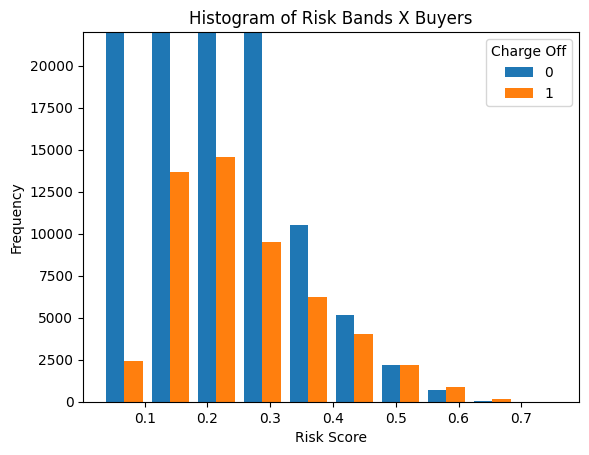

In [31]:
import matplotlib.pyplot as plt

# group data
grouped_data = X_test.groupby('target')['y_score']

# Histogram 1
# plt.hist([grouped_data.get_group(key) for key in grouped_data.groups.keys()], bins=5, alpha=0.5, label=grouped_data.groups.keys())
plt.hist([grouped_data.get_group(key) for key in grouped_data.groups.keys()], bins=10, alpha=1, label=[0,1])

# title
plt.title('Histogram of Risk Bands X Buyers')

# axis
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.ylim(0,22000)
# legend
plt.legend(title='Charge Off')

# show
plt.show()


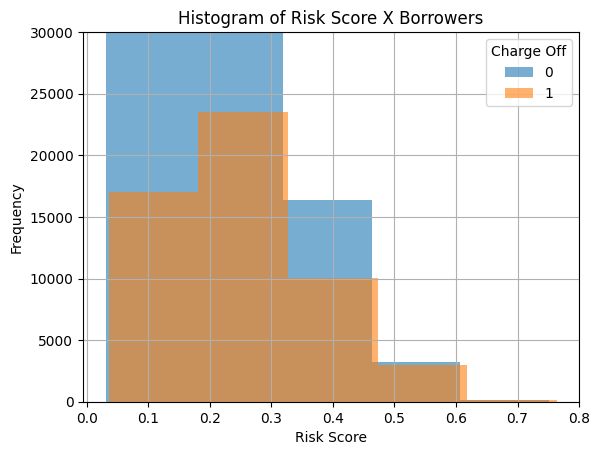

In [32]:
## Histogram 2
X_test.groupby('target')['y_score'].hist(bins=5,alpha=0.6) 
plt.title('Histogram of Risk Score X Borrowers')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.ylim(0,30000)
plt.legend(labels=[0,1],title='Charge Off')
plt.show()

In [33]:
prop_pol

,Risk Bands,Score Ranges,% of Population,% Bads,% Goods,% Risk
0,Very Low,0.0 a 0.212,65%,44.1%,70.2%,8.80%
1,Low,0.212 a 0.2931,19%,24.5%,17.6%,4.88%
2,Medium High,0.2931 a 0.3929,10%,17.4%,8.2%,3.48%
3,High,0.3929 a 1.0,6%,14.1%,4.0%,2.81%


## Define and Apply Thresold to Decision

In [34]:
# Define recomendation
X_test['Risk_Recomendation'] = X_test['Risk Bands'].apply(lambda x: 1 if x in ["Medium High", "High"] else 0)

# Verify
X_test['Risk_Recomendation'].value_counts()



Risk_Recomendation
0    226011
1     43051
Name: count, dtype: int64

## Save threshold for decision

In [122]:
import joblib

threshold_medium_risk_decision = X_test[X_test['Risk Bands']=="Medium High"]['y_score'].min()
joblib.dump(threshold_medium_risk_decision, "artifacts/threshold_medium_risk_decision.joblib")

threshold_high_risk_decision = X_test[X_test['Risk Bands']=="High"]['y_score'].min()
joblib.dump(threshold_high_risk_decision, "artifacts/threshold_high_risk_decision.joblib")


['artifacts/threshold_high_risk_decision.joblib']

In [123]:
threshold_medium_risk_decision, threshold_high_risk_decision

(0.2930874712854311, 0.3928714035138371)

In [118]:
prop_pol

,Risk Bands,Score Ranges,% of Population,% Bads,% Goods,% Risk
0,Very Low,0.0 a 0.212,65%,44.1%,70.2%,8.80%
1,Low,0.212 a 0.2931,19%,24.5%,17.6%,4.88%
2,Medium High,0.2931 a 0.3929,10%,17.4%,8.2%,3.48%
3,High,0.3929 a 1.0,6%,14.1%,4.0%,2.81%


## Run streamlit.py process

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import joblib
import shap

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb


In [49]:
# df00 = pd.read_csv('input/df.csv')
df00 = pd.read_csv('input/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv')


In [86]:
import joblib
metadata = pd.read_csv('artifacts/metadata.csv')

mean_vars_num = joblib.load('artifacts/mean_vars_num.joblib')
loaded_scaler = joblib.load('artifacts/scaler.joblib')
map_addr_state = joblib.load('artifacts/map_addr_state.joblib')

# features_used_to_train
features_used_to_train = joblib.load('artifacts/features_used_to_train.joblib')

map_addr_state


{'IA': 1,
 nan: 2,
 'ND': 3,
 'ID': 4,
 'SD': 5,
 'WY': 6,
 'VT': 7,
 'ME': 8,
 'AK': 9,
 'DC': 10,
 'MT': 11,
 'DE': 12,
 'NE': 13,
 'WV': 14,
 'RI': 15,
 'HI': 16,
 'NH': 17,
 'NM': 18,
 'MS': 19,
 'UT': 20,
 'AR': 21,
 'KS': 22,
 'OK': 23,
 'KY': 24,
 'LA': 25,
 'OR': 26,
 'AL': 27,
 'SC': 28,
 'WI': 29,
 'NV': 30,
 'TN': 31,
 'CT': 32,
 'MO': 33,
 'IN': 34,
 'MN': 35,
 'WA': 36,
 'CO': 37,
 'MA': 38,
 'AZ': 39,
 'MD': 40,
 'MI': 41,
 'NC': 42,
 'VA': 43,
 'GA': 44,
 'OH': 45,
 'PA': 46,
 'NJ': 47,
 'IL': 48,
 'FL': 49,
 'TX': 50,
 'NY': 51,
 'CA': 52}

In [116]:
print(map_addr_state.keys())

dict_keys(['IA', nan, 'ND', 'ID', 'SD', 'WY', 'VT', 'ME', 'AK', 'DC', 'MT', 'DE', 'NE', 'WV', 'RI', 'HI', 'NH', 'NM', 'MS', 'UT', 'AR', 'KS', 'OK', 'KY', 'LA', 'OR', 'AL', 'SC', 'WI', 'NV', 'TN', 'CT', 'MO', 'IN', 'MN', 'WA', 'CO', 'MA', 'AZ', 'MD', 'MI', 'NC', 'VA', 'GA', 'OH', 'PA', 'NJ', 'IL', 'FL', 'TX', 'NY', 'CA'])


In [82]:
input_user = df00[df00['id']==93952372]
select_cols = ['id',
 'loan_amnt',
 'term',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'addr_state',
 'dti',
 'mths_since_recent_inq',
 'bc_open_to_buy',
 'num_op_rev_tl',
 'loan_status']

input_user = input_user[select_cols].head(1)
input_user.head().T

,2200605
id,93952372
loan_amnt,15000.0
term,36 months
emp_length,10+ years
home_ownership,OWN
annual_inc,70000.0
addr_state,TX
dti,21.12
mths_since_recent_inq,11.0
bc_open_to_buy,4101.0


In [105]:
loan_amnt = input_user['loan_amnt'].values[0]
term = input_user['term'].values[0]
# sub_grade = input_user['sub_grade'].values[0]
home_ownership = input_user['home_ownership'].values[0]
emp_length = input_user['emp_length'].values[0]
annual_inc = input_user['annual_inc'].values[0]
dti = input_user['dti'].values[0]
mths_since_recent_inq = input_user['mths_since_recent_inq'].values[0]
# revol_util = input_user['revol_util'].values[0]
addr_state = input_user['addr_state'].values[0]
bc_open_to_buy = input_user['bc_open_to_buy'].values[0]
num_op_rev_tl = input_user['num_op_rev_tl'].values[0]

In [106]:
bc_open_to_buy

4101.0

In [108]:
def preprocess(loan_amnt, term, 
            #    sub_grade, 
            home_ownership,
               emp_length, annual_inc, dti, mths_since_recent_inq, 
            #    revol_util, 
            addr_state, bc_open_to_buy,
               num_op_rev_tl):
    # Pre-processing user input

    user_input_dict={'loan_amnt':[loan_amnt], 'term':[term],
                    #   'sub_grade':[sub_grade], 
                      'home_ownership':[home_ownership], 
                      'emp_length':[emp_length], 'annual_inc':[annual_inc], 'dti':[dti],
                'mths_since_recent_inq':[mths_since_recent_inq], 
                # 'revol_util':[revol_util], 
                'addr_state':[addr_state],
                'bc_open_to_buy':[bc_open_to_buy],
                'num_op_rev_tl':[num_op_rev_tl]}
    user_input=pd.DataFrame(data=user_input_dict)
    display(user_input)


    #user_input=np.array(user_input)
    #user_input=user_input.reshape(1,-1)

    cleaner_type = {"term": {" 36 months": 1.0, " 60 months": 2.0},
    "addr_state": map_addr_state,
    "emp_length": {"< 1 year": 0.0, '1 year': 1.0, '2 years': 2.0, '3 years': 3.0, '4 years': 4.0,
    '5 years': 5.0, '6 years': 6.0, '7 years': 7.0, '8 years': 8.0, '9 years': 9.0,
    '10+ years': 10.0 }
    }

    user_input = user_input.replace(cleaner_type)

    user_input.home_ownership.replace({"ANY":"OTHERS","OTHER":"OTHERS","NONE":"OTHERS"},inplace=True)
    user_input = pd.get_dummies(user_input, 
                      columns=['home_ownership'],
                      drop_first=False, 
                      prefix ='home_ownership',
                      prefix_sep='_',
                      dtype=int)

    # Indicate all columns used to train 
    l1 = user_input.columns.tolist()
    l2 = features_used_to_train
 
    columns_to_add = list(set(l2)-set(l1))
    # Adicionando as novas colunas com valores padrão NaN
    for col in columns_to_add:
       user_input[col] = 0
 
    user_input = user_input[l2]


    # Normalization 
    # Selecting Numeric Features
    lista_vars_numericas = list(
      metadata[((metadata.Level  == 'ordinal')|(metadata.Level == 'interval')) & (metadata.Role == 'input')]
      ['Features'])

    user_input[lista_vars_numericas] = (user_input[lista_vars_numericas].fillna(mean_vars_num)
         ).astype(float)

    ## Standarlization

    # Use the loaded scaler to transform the new data
    scaled_features_new = loaded_scaler.transform(user_input[lista_vars_numericas])
    user_input[lista_vars_numericas] = scaled_features_new


    return user_input

#user_input=preprocess
user_input=preprocess(loan_amnt, term, home_ownership, emp_length, annual_inc, dti, mths_since_recent_inq,addr_state, bc_open_to_buy, num_op_rev_tl)
user_input.head()


,loan_amnt,term,home_ownership,emp_length,annual_inc,dti,mths_since_recent_inq,addr_state,bc_open_to_buy,num_op_rev_tl
0,15000.0,36 months,OWN,10+ years,70000.0,21.12,11.0,TX,4101.0,14.0


,loan_amnt,term,emp_length,annual_inc,addr_state,dti,mths_since_recent_inq,bc_open_to_buy,num_op_rev_tl,home_ownership_MORTGAGE,home_ownership_OTHERS,home_ownership_OWN,home_ownership_RENT
0,0.065237,-0.564595,1.127005,-0.087128,0.875601,0.251863,0.785456,-0.405674,1.287908,0,0,1,0


In [109]:
#prepare test set for shap explainability

model=joblib.load("artifacts/best_model.joblib")

loans = pd.read_csv("input/Test.csv")
X = loans.drop(columns=['target'])
y = loans[['target']]
y_ravel = y.values.ravel()

X.head(2)

,id,loan_amnt,term,emp_length,annual_inc,addr_state,dti,mths_since_recent_inq,bc_open_to_buy,num_op_rev_tl,home_ownership_MORTGAGE,home_ownership_OTHERS,home_ownership_OWN,home_ownership_RENT
0,93952372,0.065237,-0.564595,1.127005,-0.087128,0.875601,0.251863,0.785456,-0.405674,1.287908,0,0,1,0
1,15741465,1.211835,-0.564595,1.127005,-0.224658,-0.504480,0.778456,0.052781,-0.605990,2.188259,1,0,0,0


In [110]:
pd.concat([user_input.head(),
X[user_input.columns.tolist()].head(1)]).T

,0,0
loan_amnt,0.065237,0.065237
term,-0.564595,-0.564595
emp_length,1.127005,1.127005
annual_inc,-0.087128,-0.087128
addr_state,0.875601,0.875601
dti,0.251863,0.251863
mths_since_recent_inq,0.785456,0.785456
bc_open_to_buy,-0.405674,-0.405674
num_op_rev_tl,1.287908,1.287908
home_ownership_MORTGAGE,0.000000,0.000000


In [111]:
Train = pd.read_csv('input/Train.csv', index_col='id')
X_train = Train.drop(['target'], axis=1)
X_train.columns

Index(['loan_amnt', 'term', 'emp_length', 'annual_inc', 'addr_state', 'dti',
       'mths_since_recent_inq', 'bc_open_to_buy', 'num_op_rev_tl',
       'home_ownership_MORTGAGE', 'home_ownership_OTHERS',
       'home_ownership_OWN', 'home_ownership_RENT'],
      dtype='object')

Result Interpretability - Applicant Level


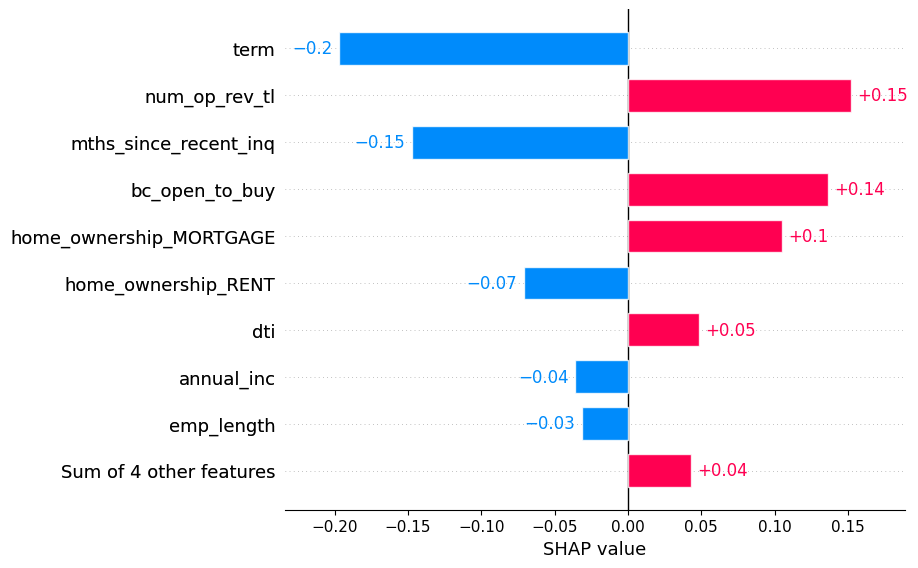

In [112]:
print('Result Interpretability - Applicant Level')
shap.initjs()
explainer = shap.Explainer(model, X_train)
shap_values = explainer(user_input)
fig = shap.plots.bar(shap_values[0])
# st.pyplot(fig)



Model Interpretability - Overall


100%|===================| 268825/269062 [08:19<00:00]        

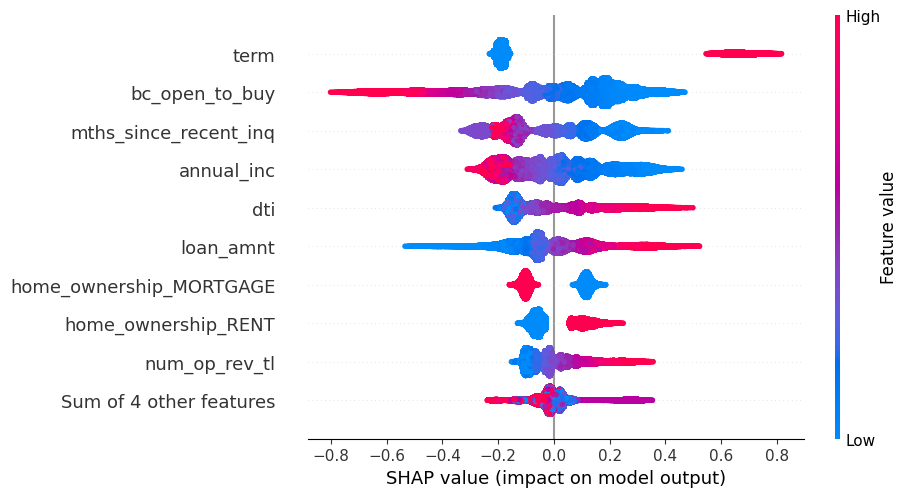

In [127]:
print('Model Interpretability - Overall')
X_test = pd.read_csv("input/Val.csv")
X_test.set_index('id',inplace=True)
X_test = X_test.drop(columns=['target'])

# Cria uma figura do matplotlib
plt.figure(figsize=(10,5))
shap_values_ttl = explainer(X_test)
shap.plots.beeswarm(shap_values_ttl,show=False)
# st.pyplot(fig_ttl)
# Salva a figura
plt.savefig('images/shap_plot.png')